# Predicting whether or not a song is popular/hot or not based on the Billboard top 100 charts

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, GridSearchCV
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost.sklearn import XGBRegressor, XGBClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier
import copy
from sklearn import svm, preprocessing
from sklearn.metrics import r2_score, roc_auc_score, roc_curve, auc, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier

%matplotlib inline

/Users/samlundberg/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
df=pd.read_csv('./data/datacleanedwithbb.csv')

In [3]:
df.shape

(9995, 54)

In [4]:
#since the BillBoard Top 100 started in August 1958, we need to remove all records prior to 1958
df['year']=df['year'].astype(int)
df=df.loc[df['year'] > 1958]

In [5]:
#unfortunately this cuts our sample in half
df.shape

(4643, 54)

In [6]:
#look for null values
null_counts = df.isnull().sum()
null_counts[null_counts > 0].sort_values(ascending=False)

artist_longitude            2848
artist_latitude             2848
artist_location             1617
song_hotttnesss             1582
bars_confidence_mean          15
bars_start_mean               15
beats_confidence_mean         12
beats_start_mean              12
sections_confidence_mean      10
sections_start_mean           10
tatums_confidence_mean         8
tatums_start_mean              8
dtype: int64

In [7]:
#Clean up some columns initially left untouched for flexibility
df.drop(['Unnamed: 0'], axis=1, inplace=True)
df['artist_location']=df['artist_location'].replace("NaN","None")
df['artist_location']=df['artist_location'].fillna('None')
df['artist_longitude']=df['artist_longitude'].replace("NaN",0)
df['artist_longitude']=df['artist_longitude'].fillna(0)
df['artist_latitude']=df['artist_latitude'].replace("NaN",0)
df['artist_latitude']=df['artist_latitude'].fillna(0)

In [8]:
#for this purpose, we are removing all rows that have a null value for song hottness or a 0 value
df["artist_familiarity"] = df["artist_familiarity"].fillna(df["artist_familiarity"].median())
df.dropna(subset=['song_hotttnesss'], inplace=True) 
df['song_hotttnesss']=df[df.song_hotttnesss != 0]
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

In [9]:
#look for null values
null_counts = df.isnull().sum()
null_counts[null_counts > 0].sort_values(ascending=False)

Series([], dtype: int64)

In [10]:
df.shape

(2703, 53)

## Predicting a song's Hotness from the web-scraped feature "bb_hot" or on the Billboard Top 100

In [11]:
#label encode various columns to change from text to numerical value for modeling
le = preprocessing.LabelEncoder()
df['artist_name_orig']=df['artist_name'].copy()
df['artist_id_orig']=df['artist_id'].copy()
df['artist_location_orig']=df['artist_location'].copy()
df['genre_orig']=df['genre'].copy()

df['artist_name'] = le.fit_transform(df['artist_name'].values)
df['artist_id'] = le.fit_transform(df['artist_id'].values)
df['artist_location'] = le.fit_transform(df['artist_location'].values)
df['genre'] = le.fit_transform(df['genre'].values)

In [12]:
#Create Variables for modeling

#create X variable

#removing confidence features as they seem to be creating bias in the modeling
features=df[['artist_familiarity', 'artist_hotttnesss','artist_name','duration','artist_latitude', 
             'artist_longitude','end_of_fade_in', 'key', 'loudness', 'mode', 'artist_id' ,
             'start_of_fade_out', 'tempo', 'time_signature','year', 'artist_location', 
             'segments_start_mean','segments_pitches_mean','segments_timbre_mean',
             'segments_loudness_max_mean','segments_loudness_max_time_mean',
             'segments_loudness_start_mean','beats_start_mean','bars_start_mean','tatums_start_mean',
             'genre']]


X=features

#create y variable
#df['bb_hot']=df.bb_hot.astype(int)
y = copy.deepcopy(df.bb_hot)

#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [13]:
#function to evaluate models with cross validation

def testingModel(model, X_train, y_train):
    scores = cross_val_score(model, X_train, y_train, cv=10, scoring = "roc_auc")
    print("Scores            :", scores)
    print("Mean              :", scores.mean())
    print("Standard Deviation:", scores.std())
    return scores.mean()

In [14]:
#Tried Gridsearch but couldn't improve the model
model = XGBClassifier()
model.fit(X_train, y_train)
# make predictions for test data
y_pred = model.predict(X_test)
accuracy = model.score(X_test, y_test)
print("Accuracy: %.2f%%" % (accuracy))
acc_xgb = testingModel(model, X_train, y_train)

/Users/samlundberg/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/samlundberg/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Accuracy: 0.87%
Scores            : [0.60436474 0.62424373 0.40743155 0.46045198 0.51564537 0.58440678
 0.60338983 0.55954802 0.55706215 0.56271186]
Mean              : 0.5479256014727355
Standard Deviation: 0.06502799956196338


In [15]:
rf = RandomForestClassifier(n_estimators=100, oob_score = True)
rf.fit(X_train, y_train)
accuracy_rr = rf.score(X_test, y_test)
print("Accuracy: %.2f%%" % (accuracy_rr))
acc_random_forest = testingModel(rf, X_train, y_train)

Accuracy: 0.87%
Scores            : [0.57508643 0.6150605  0.50401999 0.45610604 0.53780965 0.48836158
 0.52271186 0.55039548 0.61536723 0.52723164]
Mean              : 0.5392150408469204
Standard Deviation: 0.049105246583716976


In [16]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
accuracy_lr = lr.score(X_test, y_test)
print("Accuracy: %.2f%%" % (accuracy_lr))

acc_log = testingModel(lr, X_train, y_train)

Accuracy: 0.87%
Scores            : [0.53694901 0.60587727 0.46697088 0.45827901 0.56779661 0.58983051
 0.48       0.58644068 0.56045198 0.58666667]
Mean              : 0.54392626068783
Standard Deviation: 0.052739993467940095


In [17]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, y_train)
accuracy_knn = knn.score(X_test, y_test)
print("Accuracy: %.2f%%" % (accuracy_knn))
acc_knn = testingModel(knn, X_train, y_train)

Accuracy: 0.85%
Scores            : [0.48314607 0.61678911 0.53302912 0.47142547 0.48913516 0.55559322
 0.56666667 0.54689266 0.56293785 0.59514124]
Mean              : 0.5420756559190191
Standard Deviation: 0.04581769908994173


In [18]:
linear_svc = LinearSVC()
linear_svc.fit(X_train, y_train)
accuracy_linear_svc = linear_svc.score(X_test, y_test)
print("Accuracy: %.2f%%" % (accuracy_linear_svc))
acc_linear_svc = testingModel(linear_svc, X_train, y_train)

Accuracy: 0.87%
Scores            : [0.56892826 0.57411409 0.58648414 0.49891352 0.58018253 0.4960452
 0.51096045 0.56338983 0.64429379 0.4779661 ]
Mean              : 0.5501277900668493
Standard Deviation: 0.04948353898199343


In [19]:
#combine and display model results
results = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression','Random Forest', 'XGB'],
    'Score': [acc_linear_svc, acc_knn, acc_log, acc_random_forest, acc_xgb]})
result_df = results.sort_values(by='Score', ascending=False)
#result_df = result_df.set_index('Score')
result_df.head(10)

,Model,Score
0,Support Vector Machines,0.550128
4,XGB,0.547926
2,Logistic Regression,0.543926
1,KNN,0.542076
3,Random Forest,0.539215


### Extreme Gradient Boost (XGB) is the best performing model, lets run GridSearch to further tune the model

In [20]:
# #surprisingly, tuning the model doesn't help much
# params = {'min_child_weight':[4,5], 'gamma':[i/10.0 for i in range(3,6)],  'subsample':[i/10.0 for i in range(6,11)],
#           'colsample_bytree':[i/10.0 for i in range(6,11)], 'max_depth': [3,4,5,6], 'n_estimators':[10], 
#           'learning_rate': [.1, .2, .3], 'n_threads':[-2,-1,0,1,2]}

# gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=100, max_depth=5,
#                         min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
#                         objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=42, n_threads=-1), 
#                         param_grid = params, scoring='roc_auc',n_jobs=4,iid=False, cv=5, verbose=False)
# gsearch1.fit(X_train,y_train)
# test_best_score=gsearch1.score(X_test, y_test)
# gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_, test_best_score

## Based off of the feature "bb_hot", or if a song showed up in the BillBoard Top 100 charts, around 55% of the time, the model can predict if a song would show up in the Top 100 charts, according to BillBoard.  This includes features of the song, as well as location of an artist, etc. 

## Evaluating the model

In [21]:
y_hat = model.predict(X_test)
y_hat_train = model.predict(X_train)
y_hat_prob = model.predict_proba(X_test)

/Users/samlundberg/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/samlundberg/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [22]:
y_train_pred_proba = model.predict_proba(X_train)
y_train_pred = model.predict(X_train)
y_test_pred_proba = model.predict_proba(X_test)
y_test_pred = model.predict(X_test)

/Users/samlundberg/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/samlundberg/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [23]:
#modifying train and testing data to allow for changing prob thresholds and printing the roc curves
X_train.loc[:, 'actual_y'] = y_train
X_train.loc[:, 'predicted_label'] = y_train_pred
X_train.loc[:, 'predicted_proba'] = y_train_pred_proba[:, 1]

X_test.loc[:, 'actual_y'] = y_test
X_test.loc[:, 'predicted_label'] = y_test_pred
X_test.loc[:, 'predicted_proba'] = y_test_pred_proba[:, 1]

/Users/samlundberg/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/samlundberg/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s



|TN|FP|
---|----
|FN|TP|

In [24]:
confusion_matrix(y_train, y_hat_train)

array([[1772,    0],
       [ 240,   15]])

In [25]:
confusion_matrix(y_test, y_hat)

array([[588,   1],
       [ 87,   0]])

In [26]:
print(classification_report( y_train, y_hat_train))

             precision    recall  f1-score   support

          0       0.88      1.00      0.94      1772
          1       1.00      0.06      0.11       255

avg / total       0.90      0.88      0.83      2027



In [27]:
print(classification_report(y_test, y_hat))

             precision    recall  f1-score   support

          0       0.87      1.00      0.93       589
          1       0.00      0.00      0.00        87

avg / total       0.76      0.87      0.81       676



In [28]:
#changing probability threshold
X.loc[:, 'predicted_label'] = X_test['predicted_proba'].map(lambda p: 1 if p > .5 else 0)

In [29]:
fpr_test, tpr_test, _ = roc_curve(y_test, X_test['predicted_proba'])
roc_auc_test = auc(fpr_test, tpr_test)

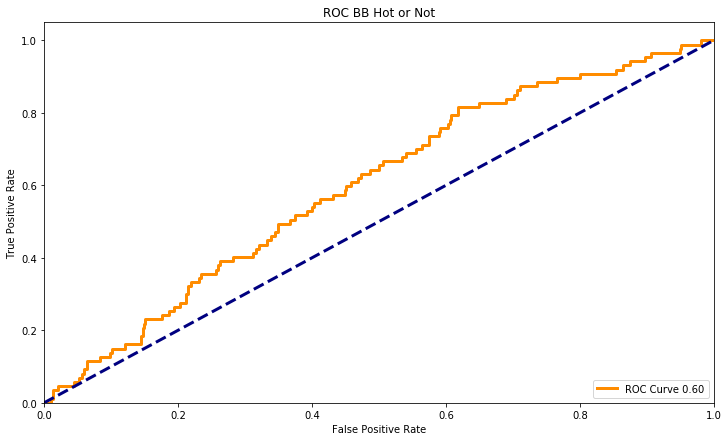

In [30]:
# Plot ROC Curve
plt.figure(figsize = (12,7))
line_width = 3

plt.plot(fpr_test, tpr_test, lw = line_width, color="darkorange", label = "ROC Curve %.2f" % roc_auc_test)
plt.plot([0,1], [0, 1], lw = line_width, linestyle="--", color="navy")

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC BB Hot or Not')
plt.legend(loc="lower right")
plt.show()

## Sensitivity indicates how many of the positives are actually identified as positive.  In this case, we are interested in the relationship between accuracy and how many of the songs were predicted as Hot or Not.  The model had accuracy of 56.2% and has a very low sensitivity score, which shows that the model is predicting less than ideal.  Identifying True Positives and minimizing True Negatives is the goal here

### The function below will search for the best combination of accuracy, sensitivity and specificity.  

In [58]:
# #print out confusion matrices from .1 to .3 by .01 for Xtest and Xtrain
# for prob in range(100,300, 10):
#     proba = prob/1000
    
#     X_test.loc[:, 'predicted_label']= X_test['predicted_proba'].map(
#     lambda p: 1 if p > proba else 0)
    
#     X_train.loc[:, 'predicted_label']= X_train['predicted_proba'].map(
#     lambda p: 1 if p > proba else 0)
    
#     tn, fp, fn, tp = confusion_matrix(y_test, X_test['predicted_label']).ravel()
    
#     X_test['predicted_label']
#     print('Test  ' + str(proba))
#     print(confusion_matrix(y_test, X_test['predicted_label']))
#     print("Accuracy    : ", accuracy_score(y_test,X_test['predicted_label'] ))
#     print("Specificity : ", tn/(tn+fp))
#     print("Sensitivity : ", tp/(tp+fn))
#     print("Precision   : ", tp/(tp + fp))
#     #print(classification_report(y_test, X_test['predicted_label']))
#     #print(' Train  ' + str(proba))
#     #print(confusion_matrix(y_train, X_train['predicted_label']))


### Examining all of the probabilities and changing the threshold doesn't help too much.  It might be a better model to predict if a song "won't" be hot or not...

In [32]:
#optimal threshold for predicting whether a song is hot or not to maximixe sensitivity
# Test  0.12
# [[317 272]
#  [ 34  53]]
# Accuracy    :  0.5473372781065089
# Specificity :  0.5382003395585738
# Sensitivity :  0.6091954022988506
# Precision   :  0.16307692307692306

# Visualizations of what makes a song hot or not for BillBoard Top 100 songs

## What are the important features that determine if a song is hot or not, according to the BB 100 charts?

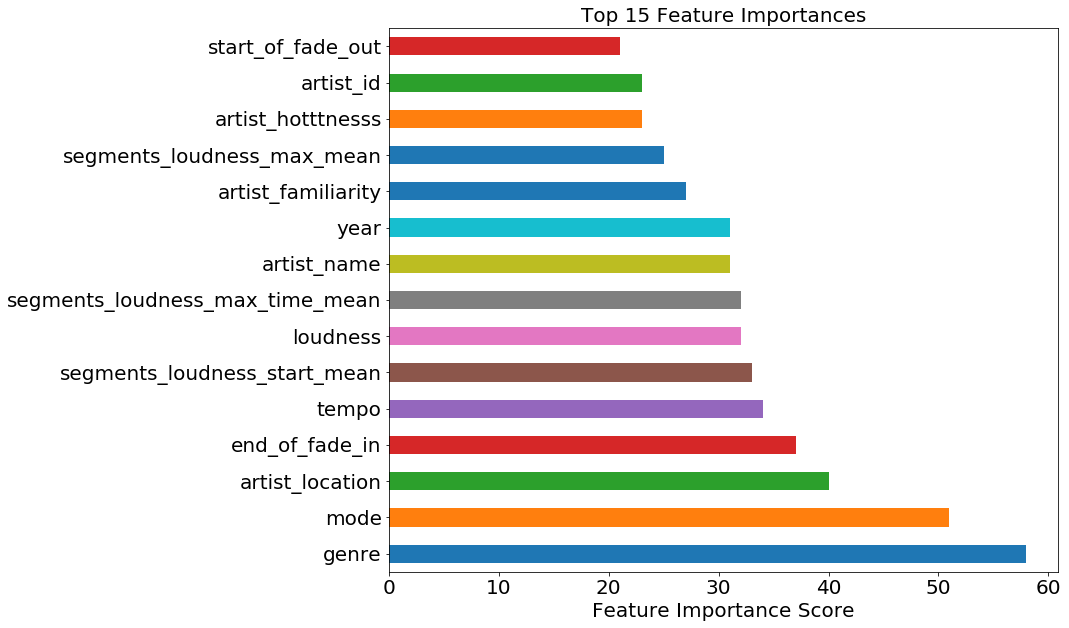

In [33]:
plt.figure(figsize=(12,10))
feat_imp = pd.Series(model.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp=feat_imp[:15]
feat_imp.plot(kind='barh', title='Feature Importances', fontsize=20)
plt.xlabel('Feature Importance Score', fontsize=20)
plt.title('Top 15 Feature Importances', fontsize=20)
plt.show()

## Genre is the biggest predictor if a song is popular or not, followed by if it is in a major or minor key, the tempo of the song, followed by how loud the song is (i.e. like heavy metal has a decibel level difference vs. smooth jazz).  Obviously, an artist everyone has heard of who has had a previous hit, helps pave the way for them to have another hit since they are already known.  

In [34]:
#function to plot different features visually compared to bb_hot 
plot_features=[['mode', 'genre','artist_hotttnesss','artist_name','tempo','loudness','artist_familiarity',
                'artist_location','segments_loudness_max_time_mean','decade']]
def freq(bbfeat):
    plt.figure(figsize=(8,8))
    g = sns.kdeplot(df[bbfeat][(df["bb_hot"] == 1)], color="Green", shade = True)
    g.set_xlabel(bbfeat, fontsize=20)
    g.set_ylabel("Frequency", fontsize=20)
    g = g.legend(["Billboard Hot"])
    plt.show()

/Users/samlundberg/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


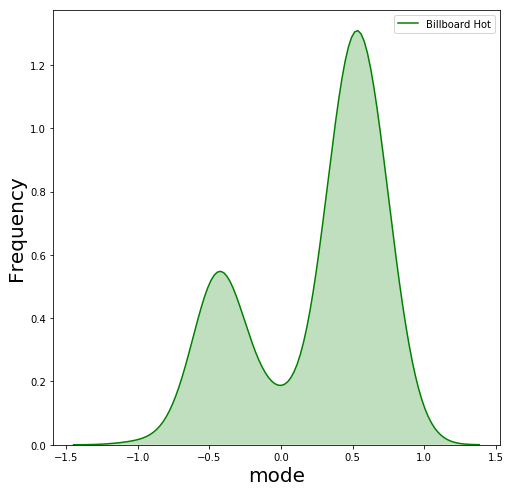

In [35]:
#major or minor, -1 to 0 is minor, 0 to 1 is major.  Most songs exist in the major category
freq('mode')

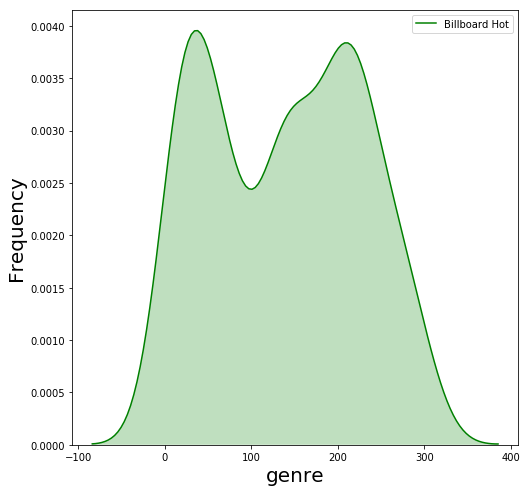

In [36]:
freq('genre')

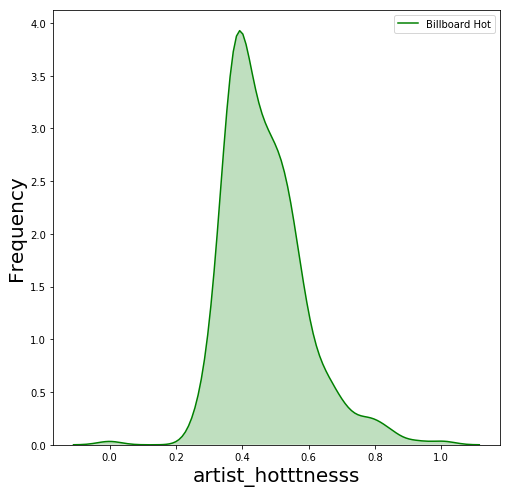

In [37]:
freq('artist_hotttnesss')

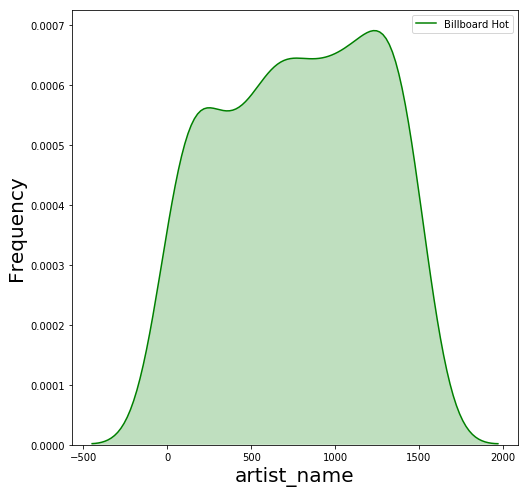

In [38]:
freq('artist_name')

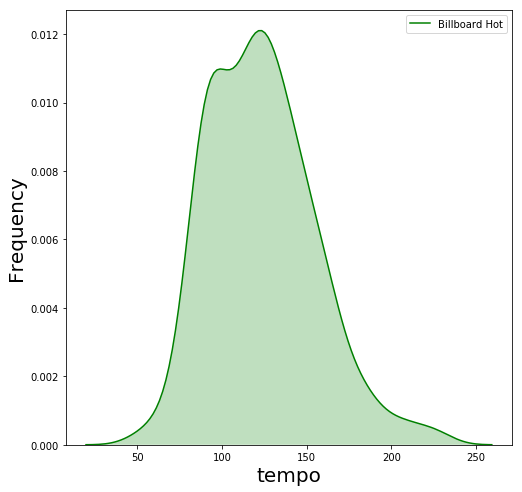

In [39]:
freq('tempo')

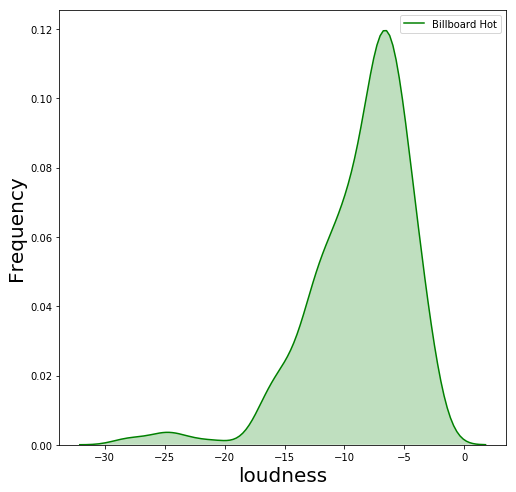

In [40]:
freq('loudness')

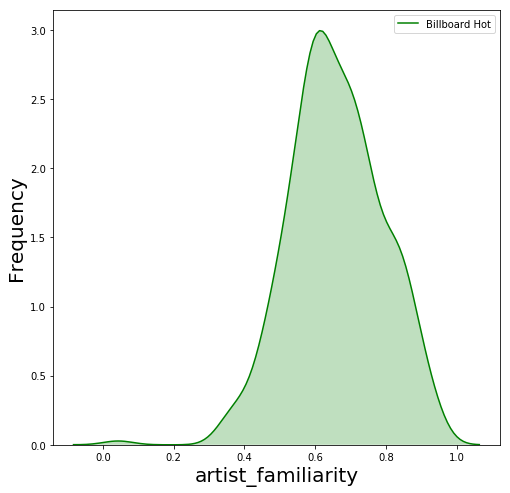

In [41]:
freq('artist_familiarity')

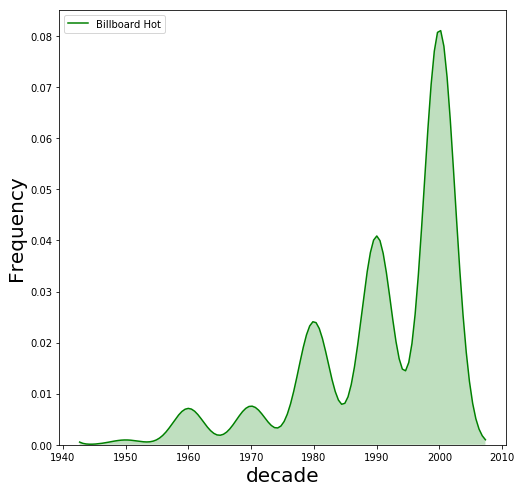

In [42]:
freq('decade')

In [43]:
#new df with just the bb_hot songs
df_bbh=df[df['bb_hot']==1]

In [44]:
#select specific columns
df_bbh=df[['tempo', 'duration', 'key', 'mode_orig', 'loudness', 'artist_familiarity', 'artist_hotttnesss']]

In [45]:
df_bbh.describe()

,tempo,duration,key,mode_orig,loudness,artist_familiarity,artist_hotttnesss
count,2703.000000,2703.000000,2703.000000,2703.000000,2703.000000,2703.000000,2703.000000
mean,126.246558,240.596618,5.312246,0.684425,-9.150911,0.650762,0.455004
std,34.740695,99.311892,3.530268,0.464831,4.925608,0.128984,0.113171
min,30.827000,31.320360,0.000000,0.000000,-41.691000,0.000000,0.000000
25%,99.521500,184.737505,2.000000,0.000000,-11.406500,0.566662,0.379707
50%,122.988000,230.059950,6.000000,1.000000,-7.992000,0.640696,0.436769
75%,148.553000,279.797095,8.000000,1.000000,-5.730000,0.737973,0.517170
max,258.677000,1598.197100,11.000000,1.000000,0.566000,1.000000,1.082503


### Artists that show up as a Billboard Top 100 artist have averages of:
- Tempo 126 BPM, Std Dev. 34.74
- Duration 240.6 seconds, Std Dev. 99.31 seconds
- Key averages key of F, but this is a deceptive stat, Std. Dev of 3.53, which puts it more in line with D or A
- Mode .68, Std Dev .46, which means 72% of songs were in major keys
- Loudness -9.1 decibels, Std Dev of 4.92
- Artist Familiarity .65, Std Dev .13 AND
- Artist Hotttnesss .45, Std Dev .1 shows there are a lot of one hit wonders, or artists that don't have a lot of hits

# This section uses a feature called "song_hotttnesss" from the original dataset to show their hot songs and relationships to other features.  The bb_hot field is just 0 and 1's, so not very useful visually.  This is plotting general song characteristics based on a song_hotttnesss from the original dataset


In [46]:
df_plots=pd.read_csv('./data/datacleanedwithbb.csv')

In [47]:
y=df_plots.song_hotttnesss

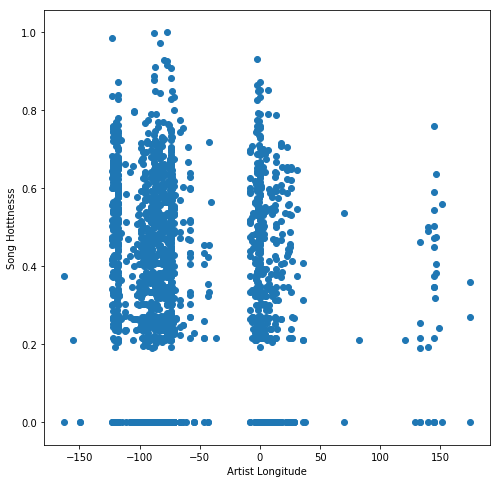

In [48]:
plt.figure(figsize=(8,8))
plt.scatter(df_plots.artist_longitude, y)
plt.xlabel('Artist Longitude')
plt.ylabel('Song Hotttnesss');

In [49]:
#For Tableau Image of artist longitude
tableau=pd.read_csv('./data/datacleanedwithbb.csv')
tableau['artist_location']=tableau['artist_location'].replace("NaN","None")
tableau['artist_location']=tableau['artist_location'].fillna('None')
tableau['artist_longitude']=tableau['artist_longitude'].replace("NaN",0)
tableau['artist_longitude']=tableau['artist_longitude'].fillna(0)
tableau['artist_latitude']=tableau['artist_latitude'].replace("NaN",0)
tableau['artist_latitude']=tableau['artist_latitude'].fillna(0)
tableau=tableau[tableau['artist_longitude'] != 0]
tn=tableau[['artist_latitude','artist_longitude','artist_hotttnesss']]
tn.reset_index(drop=True, inplace=True)
tn.to_csv('./data/datacleanedtableau.csv')

#### From Tableau, plotting the latitude/longitude on map
#### Most hot artists are in the U.S., on the coasts, while some others existing in Europe

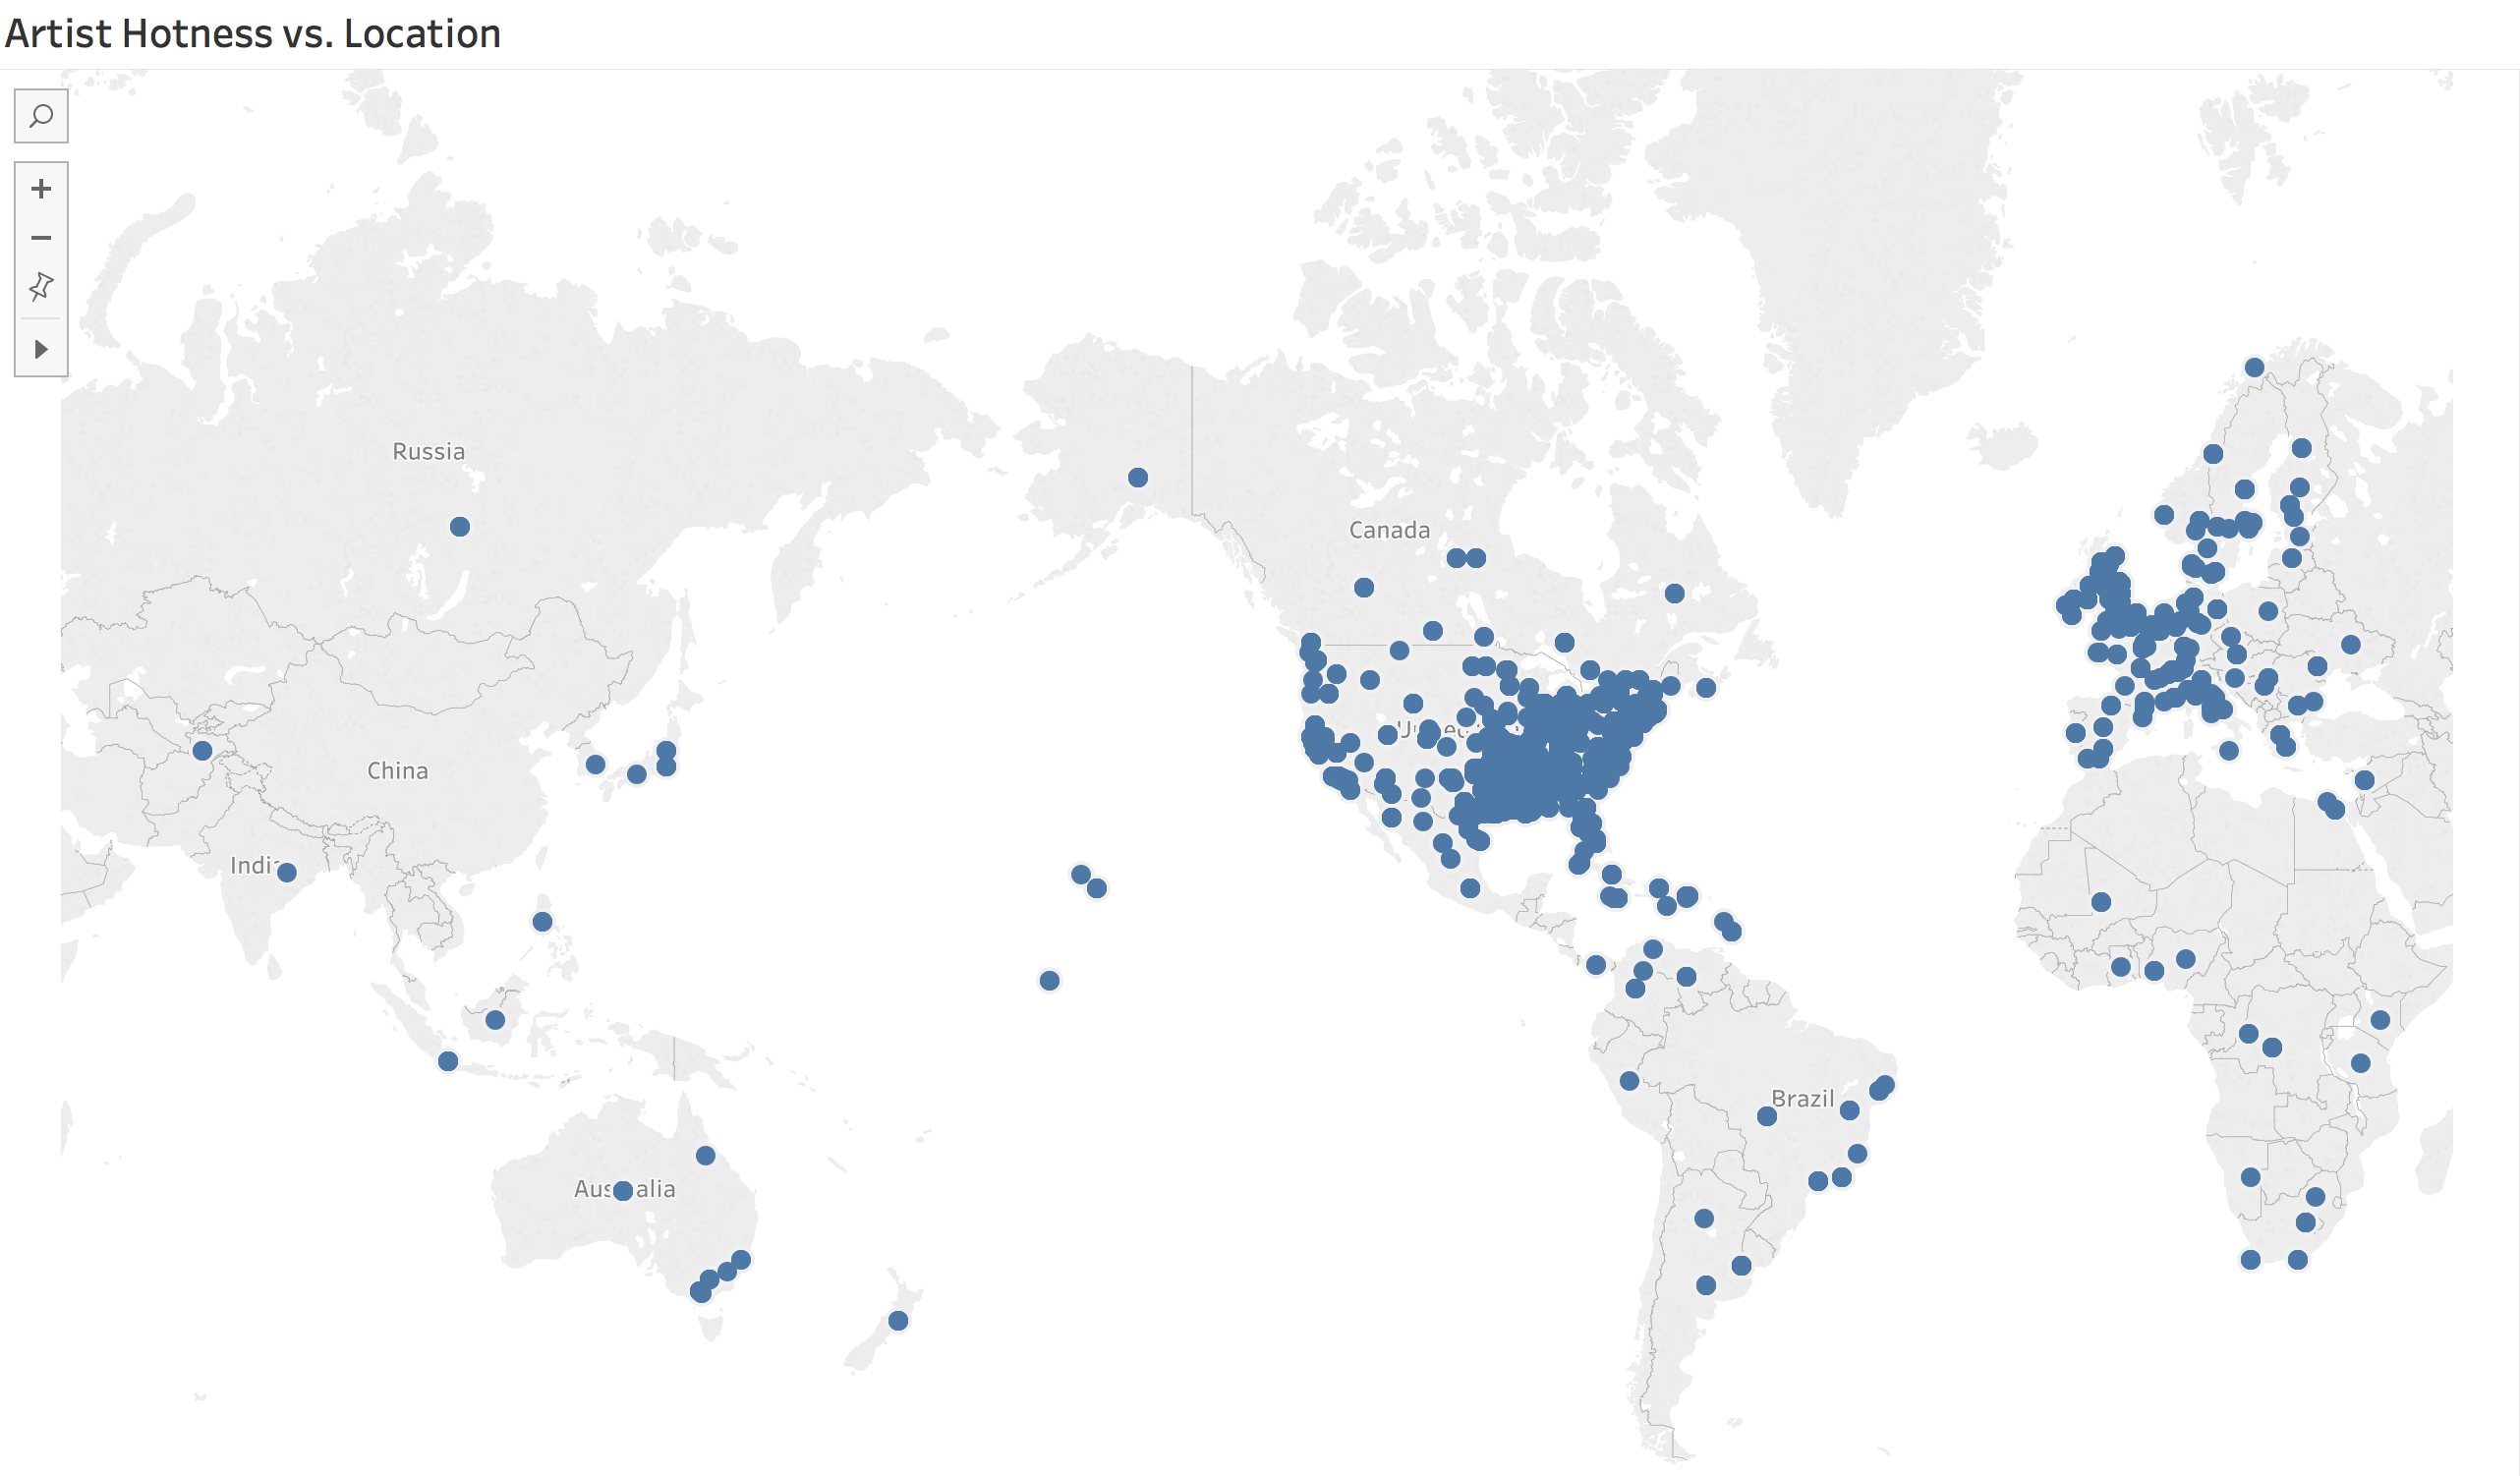

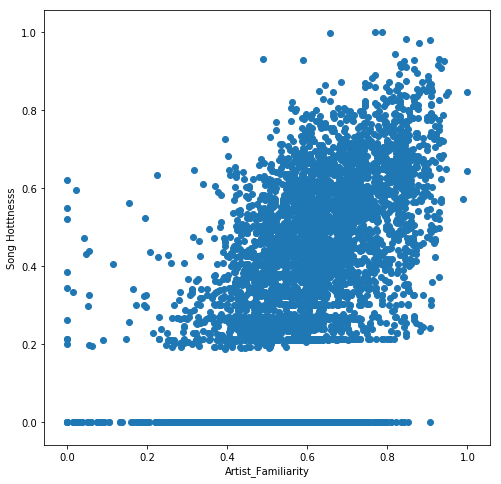

In [50]:
#the hotter the artist, the more familiar they are, no surprise here
plt.figure(figsize=(8,8))
plt.scatter(df_plots.artist_familiarity, y)
plt.xlabel('Artist_Familiarity')
plt.ylabel('Song Hotttnesss');

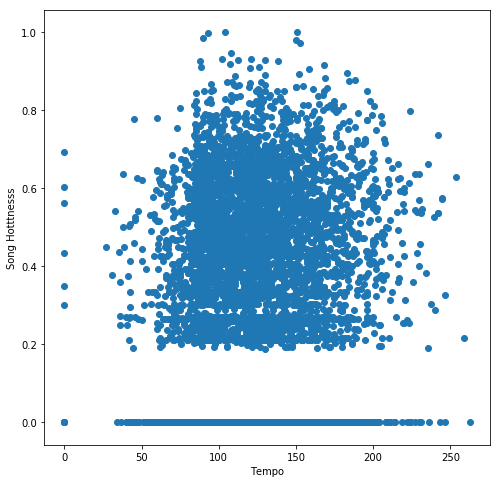

In [51]:
#the speed of a song varies, but most are between 90-160 BPM
plt.figure(figsize=(8,8))
plt.scatter(df_plots.tempo, y)
plt.xlabel('Tempo')
plt.ylabel('Song Hotttnesss');

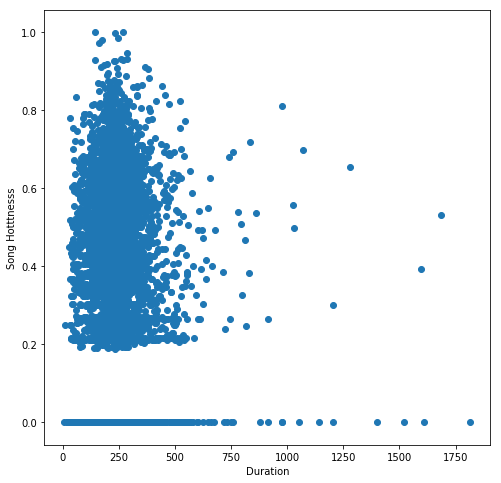

In [52]:
#the length of a song, in seconds, is most popular around 250 seconds, or around 4 minutes
plt.figure(figsize=(8,8))
plt.scatter(df_plots.duration, y)
plt.xlabel('Duration')
plt.ylabel('Song Hotttnesss');

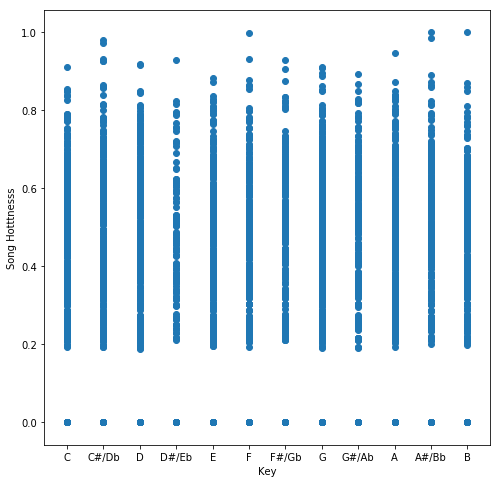

In [53]:
#the keys songs are in varies, but G, C, D are the hottest
plt.figure(figsize=(8,8))
x_label=[0,1,2,3,4,5,6,7,8,9,10,11]
labels=["C","C#/Db","D","D#/Eb","E","F","F#/Gb","G","G#/Ab","A","A#/Bb","B"]
#ax.xaxis.set_major_locator(MaxNLocator(4))
plt.xticks(x_label, labels)
plt.scatter(df_plots.key, y)
plt.xlabel('Key')
plt.ylabel('Song Hotttnesss');

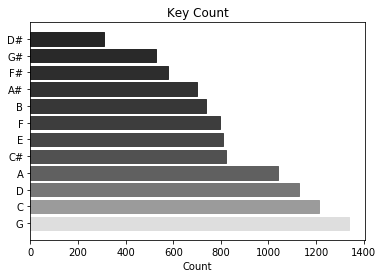

In [54]:
# key sorted horizontal bar chart
key_counts = df_plots.key.value_counts()
df_key_counts = pd.DataFrame(key_counts)
df_key_counts.reset_index(inplace = True)
# ['C','C#','D','D#','E','F','F#','G','G#','A','A#','B']
fig_key_counts, ax_key_counts = plt.subplots()
bars = ax_key_counts.barh(df_key_counts.index, df_key_counts.key)
ax_key_counts.set_yticks(df_key_counts.index)
ax_key_counts.set_yticklabels(['G','C','D','A','C#','E','F','B','A#','F#','G#','D#']);
ax_key_counts.set_title('Key Count');
ax_key_counts.set_xlabel('Count');
for x,bar in zip(range(len(bars)),bars):
    bar.set_color(str(2.0/(x+2.3)))

69.12456228114057% of songs are Major


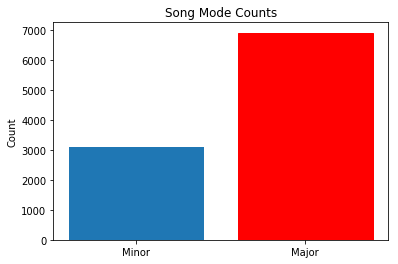

In [55]:
# song_mode bar chart
#69.12% of songs are in major keys
song_mode_counts = df_plots.mode_orig.value_counts()
fig_song_mode_counts, ax_song_mode_counts = plt.subplots();
song_mode_bars = ax_song_mode_counts.bar(song_mode_counts.index, song_mode_counts);
ax_song_mode_counts.set_xticks(song_mode_counts.index);
ax_song_mode_counts.set_xticklabels(['Major', 'Minor']);
ax_song_mode_counts.set_title('Song Mode Counts');
ax_song_mode_counts.set_ylabel('Count');
song_mode_bars[0].set_color('r');
percent_major = song_mode_counts[1] /df_plots.shape[0] * 100
print ("{}% of songs are Major".format(percent_major));

In [56]:
df_sh=df[['tempo', 'duration', 'key', 'mode_orig', 'loudness', 'artist_familiarity', 'artist_hotttnesss']]

In [57]:
df_sh.describe()

,tempo,duration,key,mode_orig,loudness,artist_familiarity,artist_hotttnesss
count,2703.000000,2703.000000,2703.000000,2703.000000,2703.000000,2703.000000,2703.000000
mean,126.246558,240.596618,5.312246,0.684425,-9.150911,0.650762,0.455004
std,34.740695,99.311892,3.530268,0.464831,4.925608,0.128984,0.113171
min,30.827000,31.320360,0.000000,0.000000,-41.691000,0.000000,0.000000
25%,99.521500,184.737505,2.000000,0.000000,-11.406500,0.566662,0.379707
50%,122.988000,230.059950,6.000000,1.000000,-7.992000,0.640696,0.436769
75%,148.553000,279.797095,8.000000,1.000000,-5.730000,0.737973,0.517170
max,258.677000,1598.197100,11.000000,1.000000,0.566000,1.000000,1.082503


### Song_hotttnesss songs have averages of:
- Tempo 126 BPM, Std Dev. 34.7
- Duration 240.6 seconds, Std Dev. 99.31 seconds
- Key averages key of F, but this is a deceptive stat, Std. Dev of 3.53, which puts it more in line with D or A
- Mode .68, Std Dev .46, which means 72% of songs were in major keys
- Loudness -9.15 decibels, Std Dev of 4.92
- Artist Familiarity .65, Std Dev .13 AND
- Artist Hotttnesss .45, Std Dev .11 shows there are a lot of one hit wonders, or artists that don't have a lot of hits

## Comparing the features of Artist Hotttness vs Song Hotttnesss shows that they are very close in values.  There are slight variations, but they really are pretty close, so one could come to the conclusion a song's hotness is related to the hotness of the artist.  Artists that are more well known are more likely to have a hot song.  If you are an artist looking for the framework for a hot song, you could use the parameters above (tempo, duration, key, etc.) to get you started.  There are obviously exceptions to everything, but using knowledge of what is on popular radio, it is easy to start inferring why songs end up being played over and over and over again.  

## Outside of the scope of this analysis, looking at social/polictical trends would be interesting to include to see if those adjust the meter in the popularity of a song.  As society changes, tastes in music changes.  Look at the 70's vs. 80's vs. 90's vs. now.  Big differences in sounds and what is popular or not.  What the public will embrace is always going to be an unknown and probably ultimately depends on the record label pushing a song hard or not to be the real driver of a popular song